<a href="https://colab.research.google.com/github/jgdshkovi/Benn/blob/master/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/My Drive/Z/filter_pruning

/content/drive/My Drive/Z/filter_pruning


In [0]:
import argparse
from numpy import unique
from numpy import where
import numpy as np
import os

import math
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms

from models import *

from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
import seaborn as sns


In [0]:
test_batch_size = 256
dataset = 'cifar10'
cfg = [32, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 256, 256, 256, 'M', 256, 256, 256]
cuda = True

In [0]:
model = torch.load('L1_logs/model_best.pth.tar')
checkpoint = torch.load('L1_logs/checkpoint.pth.tar')

In [5]:
model = vgg(dataset='cifar10', depth=16,cfg=cfg)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [0]:
def test(model):
    kwargs = {'num_workers': 1, 'pin_memory': True} if True else {}
    if dataset == 'cifar10':
        test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('./data.cifar10', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])),
            batch_size=test_batch_size, shuffle=True, **kwargs)
    elif dataset == 'cifar100':
        test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100('./data.cifar100', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])),
            batch_size=test_batch_size, shuffle=True, **kwargs)
    else:
        raise ValueError("No valid dataset is given.")
    model.eval()
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    print('\nTest set: Accuracy: {}/{} ({:.1f}%)\n'.format(
        correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    return correct / float(len(test_loader.dataset))

In [0]:
cos = nn.CosineSimilarity()
from collections import defaultdict
def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items() if len(locs)>1)


def return_mask(wts, labels):
	modsource = labels.copy()
	#print(wts)
	#print(labels)
	for dup in sorted(list_duplicates(labels)):
	    #print(dup)
	    lis = dup[1][1:]
	    a = torch.from_numpy(np.reshape(wts[dup[1][0]],(1,wts[dup[1][0]].size)))
	    #a = wts[dup[1][0]]
	    for i in lis:
	    	b = torch.from_numpy(np.reshape(wts[i],(1,wts[i].size)))
	    	#print(i)
	    	simi = (cos(a,b))
	    	dis = distance.euclidean(a,b)
	    	#print(dis)
	    	#print(simi)
	    	if simi>0.5:
	    	  #print('....................')
	    	  modsource[i] = -1
	#print((modsource))
	mask = []
	for el in modsource:
		if el!=-1:
			mask.append(1)
		else:
			mask.append(0)
	#print((mask))
	return mask

def return_euc_mask(wts, labels):
  modsource = labels.copy()
  over = []
  for dup in sorted(list_duplicates(labels)):
    lis = dup[1]
    #print(lis)
    liss = []
    for i in lis:
      for j in lis:
        if i!=j:
          s = set((i,j))
          if s not in over:
            over.append(s)
            a = wts[i]
            b = wts[j]
            dis = distance.euclidean(a,b)
            liss.append(dis)
            #print(a,b,dis)
    #print('max;',end='')
    #print(max(liss))
    #print('min;',end='')
    #print(min(liss))
    #thres = (min(liss)+max(liss)) /2
    #print('thres',end='')
    #print(thres)
    #print(sorted(liss))
    th = np.median(liss)
    th = th - th*0.2
    #print('thres',end='')
    #print(th)
    #print(np.median(liss))
    #from scipy.stats import gmean
    #gm = gmean(liss)
    #print(gm)

    over = []
    for i in lis:
      for j in lis:
        if i!=j:
          if ( modsource[i]!=-2 or modsource[j]!=-2 ):
            s = set((i,j))
            if s not in over:
              over.append(s)
              a = wts[i]
              b = wts[j]
              dis = distance.euclidean(a,b)
              if dis<th:
                chk = False
                if len(lis[lis.index(j):])>1:
                  for k in lis[lis.index(j)+1:]:
                    if distance.euclidean(b,wts[k])<th:
                      chk = True
                      break
                if chk==False:
                  modsource[j]=-2
  mask = []
  for el in modsource:
    if el!=-2:
      mask.append(1)
    else:
      mask.append(0)
  #print((mask))
  return mask

def return_std_euc_mask(wts, labels):
  modsource = labels.copy()
  for dup in sorted(list_duplicates(labels)):
    lis = dup[1][1:]
    for i in lis:
      modsource[i]=-3
  
  mask = []
  for el in modsource:
    if el!=-3:
      mask.append(1)
    else:
      mask.append(0)
  return mask
  

def calc_distance(x1, y1, a, b, c):
  d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
  return d

ress = [0]
z1 = []
z2 = []

def optk(X, shp):
  global ress,z1,z2
  z1 = z2 = []
  ress = [0]
  maxdis_k = 0
  iterations = 20*shp//100
  count = 1

  dist_points_from_cluster_center = [0]
  distance_of_points_from_line = [0]

  spt = KMeans(n_clusters=1, random_state=10).fit(X)
  ept = KMeans(n_clusters=shp, random_state=10).fit(X)

  a = spt.inertia_ - ept.inertia_
  b = shp - 1
  c1 = 1 * ept.inertia_
  c2 = shp * spt.inertia_
  c = c1 - c2
  #print(a,b,c)
  z1.append(0)
  ress.append(spt.labels_)
  dist_points_from_cluster_center.append(spt.inertia_)
  distance_of_points_from_line.append(
        calc_distance(1, dist_points_from_cluster_center[1], a, b, c))
  z1.append(1)

  for k in range(2,shp):
    if count<iterations:
      res = KMeans(n_clusters=k, random_state=10).fit(X)
      ress.append(res.labels_)
      dist_points_from_cluster_center.append(res.inertia_)
      dis = calc_distance(k, dist_points_from_cluster_center[k], a, b, c)
      distance_of_points_from_line.append(dis)
      z1.append(k)
      if dis > distance_of_points_from_line[maxdis_k]:
        maxdis_k = k
        count = 0
      else:
        count += 1
    else:
      break

  ress.append(ept.labels_)
  dist_points_from_cluster_center.append(ept.inertia_)
  distance_of_points_from_line.append(
        calc_distance(shp, dist_points_from_cluster_center[-1], a, b, c))
  z1.append(shp)
  z2 = dist_points_from_cluster_center
  #plt.plot(list(range(1,shp+1)),dist_points_from_cluster_center)
  return maxdis_k

def return_std_labels(X,shp):
  res = KMeans(n_clusters=shp//2, random_state=10).fit(X)
  return res.labels_

def return_cluster_labels(feat_wts, shp):
  k = optk(feat_wts, shp)
  print('opt k:',end='')
  print(k)
  return ress[k] 

In [0]:
def formclus(X, noc):
  mod = KMeans(n_clusters=noc)
  mod.fit(X)
  yhat = mod.predict(X)
  clusters = unique(yhat)
  for cluster in clusters:
    row_ix = where(yhat == cluster)
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

In [0]:
def applyTSNE(X):
  shp = X.shape[1]
  if shp<50:
    noc = shp
  else:
    noc = 50
  pca50 = PCA(n_components=noc)
  pca50res = pca50.fit_transform(X)
  fashion_pca_tsne = TSNE(random_state=10).fit_transform(pca50res)
  xs = fashion_pca_tsne[:,0]
  ys = fashion_pca_tsne[:,1]

  Y = []
  for x,y in zip(xs,ys):
	  Y.append([x,y])
  Y = np.array(Y)
  return Y

  #find opt k here
  formclus(Y, noc=k)
  plt.show()

torch.Size([32, 3, 3, 3])
mask len:16


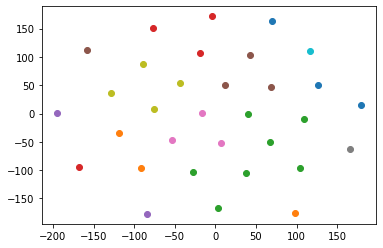

torch.Size([64, 32, 3, 3])
mask len:32


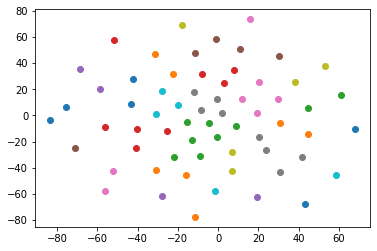

torch.Size([128, 64, 3, 3])
mask len:64


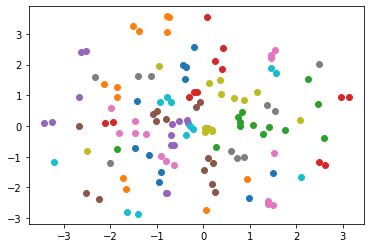

torch.Size([128, 128, 3, 3])
mask len:64


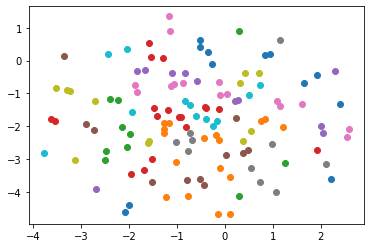

torch.Size([256, 128, 3, 3])
mask len:128


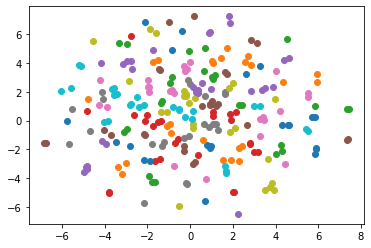

torch.Size([256, 256, 3, 3])
mask len:128


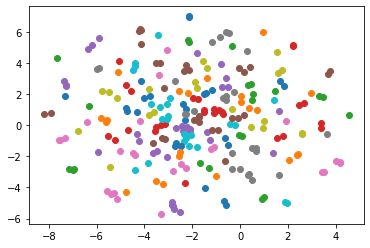

torch.Size([256, 256, 3, 3])
mask len:128


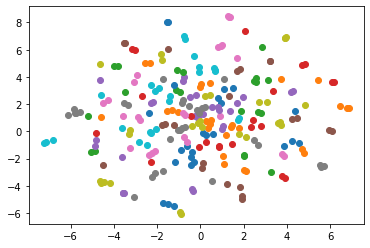

torch.Size([256, 256, 3, 3])
mask len:128


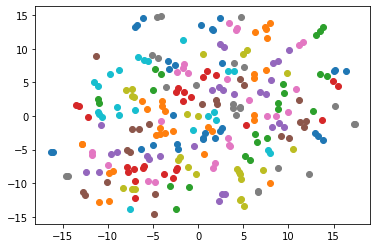

torch.Size([256, 256, 3, 3])
mask len:128


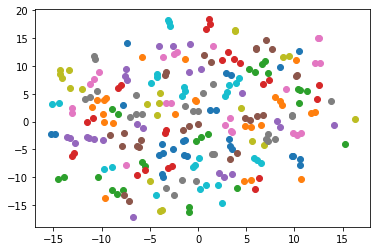

torch.Size([256, 256, 3, 3])
mask len:128


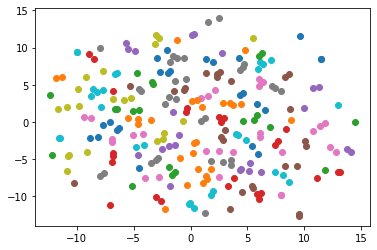

torch.Size([256, 256, 3, 3])
mask len:128


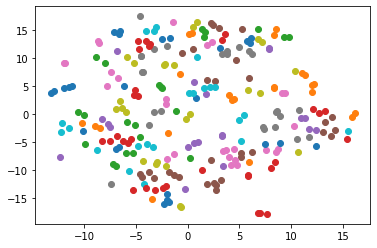

torch.Size([256, 256, 3, 3])
mask len:128


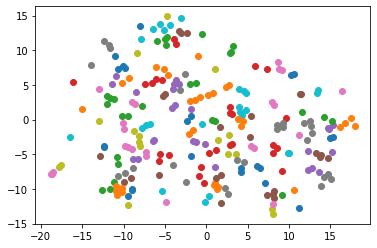

torch.Size([256, 256, 3, 3])
mask len:128


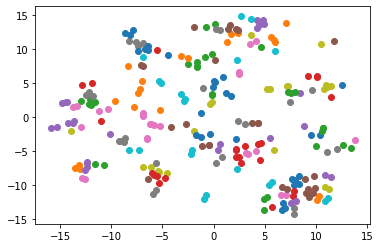

[16, 32, 'M', 64, 64, 'M', 128, 128, 128, 'M', 128, 128, 128, 'M', 128, 128, 128]


In [106]:
cos_cfg = []
cfg_mask = []
layer_id = 0
for m in model.modules():
  if isinstance(m , nn.Conv2d):
    shape = m.weight.data.shape
    print(shape)
    reshaped_tensor = m.weight.data.clone().numpy().reshape(shape[0] , shape[1]*shape[2]*shape[3])
    
    Y = applyTSNE(reshaped_tensor)

    #labels = return_cluster_labels(Y,shape[0])  #filtered_cfg[layer_id])
    labels = return_std_labels(reshaped_tensor,shape[0])
    mask = return_std_euc_mask(Y, labels)
    #break
    #mask = return_mask(Y,labels)
    #print(mask)
    #print('no of labels:',end='')
    k = len(set(labels))
    #print(len(set(labels)))
    print('mask len:',end='')
    print(sum(mask))
    cos_cfg.append(sum(mask))
    cfg_mask.append(torch.tensor(mask))
    
    formclus(Y, noc=k)
    plt.show()

    layer_id += 1
    #break
    
  elif isinstance(m, nn.MaxPool2d):
    layer_id += 1
    cos_cfg.append('M')
  #if layer_id>3:
    #break
print(cos_cfg)

In [0]:
[24, 46, 'M', 105, 102, 'M', 213, 219, 217, 'M', 218, 217, 213, 'M', 231, 223, 228]
[29, 46, 'M', 93] 0.2
[24, 46, 'M', 99]
[16, 24, 'M', 40]
[22, 43, 'M', 108]

In [107]:
newmodel = vgg(dataset = 'cifar10' ,cfg=cos_cfg)
newmodel.cuda()

start_mask = torch.ones(3)
layer_id_in_cfg = 0
end_mask = cfg_mask[layer_id_in_cfg]
for [m0, m1] in zip(model.modules(), newmodel.modules()):
    if isinstance(m0, nn.BatchNorm2d):
        idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
        if idx1.size == 1:
            idx1 = np.resize(idx1,(1,))
        m1.weight.data = m0.weight.data[idx1.tolist()].clone()
        m1.bias.data = m0.bias.data[idx1.tolist()].clone()
        m1.running_mean = m0.running_mean[idx1.tolist()].clone()
        m1.running_var = m0.running_var[idx1.tolist()].clone()
        layer_id_in_cfg += 1
        start_mask = end_mask
        if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
            end_mask = cfg_mask[layer_id_in_cfg]
    elif isinstance(m0, nn.Conv2d):
        idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
        idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
        print('In shape: {:d}, Out shape {:d}.'.format(idx0.size, idx1.size))
        if idx0.size == 1:
            idx0 = np.resize(idx0, (1,))
        if idx1.size == 1:
            idx1 = np.resize(idx1, (1,))
        w1 = m0.weight.data[:, idx0.tolist(), :, :].clone()
        w1 = w1[idx1.tolist(), :, :, :].clone()
        m1.weight.data = w1.clone()
    elif isinstance(m0, nn.Linear):
        if layer_id_in_cfg == len(cfg_mask):
            idx0 = np.squeeze(np.argwhere(np.asarray(cfg_mask[-1].cpu().numpy())))
            if idx0.size == 1:
                idx0 = np.resize(idx0, (1,))
            m1.weight.data = m0.weight.data[:, idx0].clone()
            m1.bias.data = m0.bias.data.clone()
            layer_id_in_cfg += 1
            continue
        m1.weight.data = m0.weight.data.clone()
        m1.bias.data = m0.bias.data.clone()
    elif isinstance(m0, nn.BatchNorm1d):
        m1.weight.data = m0.weight.data.clone()
        m1.bias.data = m0.bias.data.clone()
        m1.running_mean = m0.running_mean.clone()
        m1.running_var = m0.running_var.clone()

In shape: 3, Out shape 16.
In shape: 16, Out shape 32.
In shape: 32, Out shape 64.
In shape: 64, Out shape 64.
In shape: 64, Out shape 128.
In shape: 128, Out shape 128.
In shape: 128, Out shape 128.
In shape: 128, Out shape 128.
In shape: 128, Out shape 128.
In shape: 128, Out shape 128.
In shape: 128, Out shape 128.
In shape: 128, Out shape 128.
In shape: 128, Out shape 128.


In [108]:
torch.save({'cfg': cos_cfg, 'state_dict': newmodel.state_dict()},'Final_logs/pruned.pth.tar')
print(newmodel)
model = newmodel
model.cuda()
acc = test(model)

num_parameters = sum([param.nelement() for param in newmodel.parameters()])
with open( "Final_logs/prune.txt", "w") as fp:
    fp.write("Number of parameters: \n"+str(num_parameters)+"\n")
    fp.write("Test accuracy: \n"+str(acc)+"\n")

vgg(
  (feature): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 